In [115]:
import os, pickle, sys
import torch
import numpy as np
import loadVim as lv
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
def getDirections(model, image, label):
    image.requires_grad = True
    model.zero_grad()
    model.eval()
    output = model(image)
    loss = torch.nn.CrossEntropyLoss()(output.logits, label)
    loss.backward()

    gradient = image.grad
    random = torch.randn_like(gradient)

    # Normalize the directions
    gradient = gradient / torch.norm(gradient)
    random = random / torch.norm(random)
    return gradient, random

In [117]:
def calcLossGrid(model, image, label, scale=1, num_points=11):
    gradient, random = getDirections(model, image, label)

    # scale the directions
    gradient *= scale
    random *= scale

    # Calculate loss for all points in neighborhood of image
    X, Y = list(np.linspace(-1, 1, num_points)), list(np.linspace(-1, 1, num_points))
    # for each element in X, multiply by gradient
    XX = [gradient * eps for eps in X]
    YY = [random * eps for eps in Y]

    lossgrid = np.zeros((len(XX), len(YY)))
    for i in range(len(XX)):
        for j in range(len(YY)):
            perturbed_image = image + XX[i] + YY[j]
            # get loss of each perturbed image
            output = model(perturbed_image)
            loss = torch.nn.CrossEntropyLoss()(output.logits, label)
            lossgrid[i][j] = loss
    
    X, Y = np.meshgrid(X, Y)
    
    return X, Y, lossgrid

In [118]:
def calcClassGrid(model, image, label, scale=1, num_points=11):
    gradient, random = getDirections(model, image, label)

    # scale the directions
    gradient *= scale
    random *= scale

    # Calculate loss for all points in neighborhood of image
    X, Y = list(np.linspace(-1, 1, num_points)), list(np.linspace(-1, 1, num_points))
    # for each element in X, multiply by gradient
    XX = [gradient * eps for eps in X]
    YY = [random * eps for eps in Y]

    classgrid = np.zeros((len(XX), len(YY)))
    for i in range(len(XX)):
        for j in range(len(YY)):
            perturbed_image = image + XX[i] + YY[j]
            # get loss of each perturbed image
            output = model(perturbed_image)
            classgrid[i][j] = torch.argmax(output.logits).item()
    
    X, Y = np.meshgrid(X, Y)
    
    return X, Y, classgrid

In [119]:
def plotLossLandscape(X, Y , lossgrid, title):
    fig = plt.figure()
    fig.set_size_inches(5, 5)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, lossgrid, cmap=cm.coolwarm)
    ax.set_xlabel('Gradient Direction')
    ax.set_ylabel('Random Direction')
    ax.set_zlabel('Loss')
    ax.set_title(title)
    plt.show()
    

In [120]:
def plotDecisionBoundary(X, Y, classgrid):
    # Plot the class grid with each distinct class having a distinct color
    fig = plt.figure()
    fig.set_size_inches(5, 5)
    ax = fig.add_subplot(111)
    # Each class needs a distinct color
    plt.contourf(X, Y, classgrid, cmap='tab20')
    ax.set_xlabel('Gradient Direction')
    ax.set_ylabel('Random Direction')
    ax.set_title("Class Landscape of Image")
    plt.show()

In [121]:
model, processor = lv.prepareDownstreamVit()
transform = transforms.Compose([
        lambda image: processor(images=image, return_tensors='pt')['pixel_values'].squeeze(0)
    ])

path_data = os.path.join(os.getcwd(), 'CelebSubset/CelebVal')
path_checkpoint = os.path.join(os.getcwd(), 'models/VitA.pth')

dataset = datasets.ImageFolder(path_data, transform = transform)

loader = DataLoader(dataset, batch_size=1, shuffle=False)

checkpoint = torch.load(path_checkpoint)
model.load_state_dict(checkpoint["state_dict"])
model = model.to(device)

image, label = next(iter(loader))
image = image.to(device)
label = label.to(device)

c:\Projects\AdvAttack\.conda\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


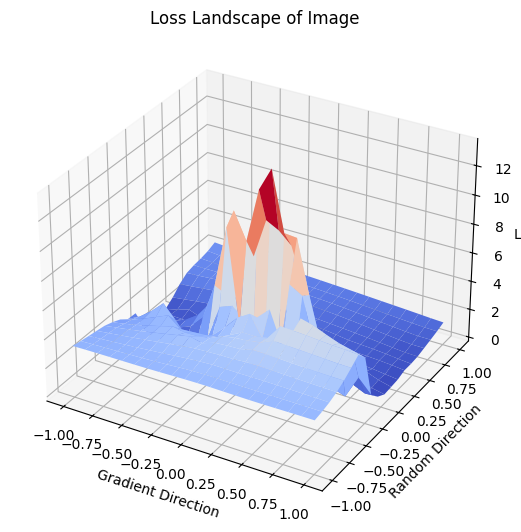

In [122]:
# High numpoints makes it a lot slower
X, Y, lossgrid = calcLossGrid(model, image, label, scale=1e3, num_points=20)
plotLossLandscape(X, Y, lossgrid, "Loss Landscape of Image")

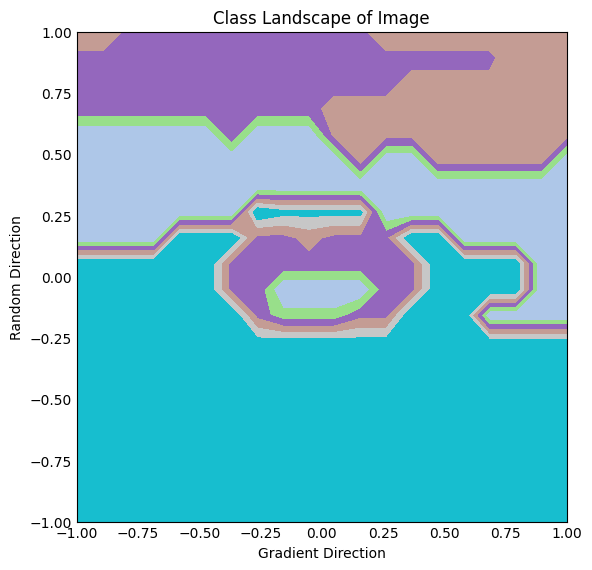

In [123]:
X, Y, classgrid = calcClassGrid(model, image, label, scale=1e3, num_points=20)
plotDecisionBoundary(X, Y, classgrid)